# The HFM library - A fast marching solver with adaptive stencils

## Part : Isotropic and anisotropic metrics
## Chapter : Asymmetric quadratic metrics

In this notebook, we demonstrate anisotropic fast marching with *asymmetric quadratic metrics*, in two and three dimensions. The metrics considered in the notebook are a generalization of Riemannian metrics, featuring an additional non-symmetric term. 
They are also a special case of non-symmetric Finslerian metrics.
An *asymmetric quadratic metric* measures vectors according to the formula:
$$
    F_x(v) := \sqrt{ \|v\|^2_{M(x)} + \max\{0,<\omega(x), v>\}^2}
$$
where $M$ is a field of symmetric positive definite tensors, and $\omega$ is a vector field. As evidenced by the above formula, the role of the vector field $\omega$ is to further penalize motion in its direction.

The HFM software computes the distance associated to a given *asymmetric quadratic metric*, and the corresponding minimal paths, by solving a variant of the eikonal PDE. Namely for all $x$ within a domain $\Omega$
$$
    \sqrt{\|\nabla u(x)\|^2_{D(x)} + \max\{0,<\eta(x),\nabla u(x)>\}^2} = 1,
$$
where $(D,\eta)$ is the dual metric.
Some algebraic formulas allow to express the dual metric in terms of $(M,\omega)$, the primal metric.

**Technical note** The two and three dimensional implementations use different discretization schemes: semi-Lagrangian, vs Eulerian. The latter one in addition involves a relaxation parameter. As a result two dimensional implementation can reach high levels of accuracy (including second/third order), whereas the three dimensional one is best used in contexts where speed and qualitative behavior are most important.

**References** The experiments presented in this notebook, or related variants, are presented in the following publications.

Mirebeau, J.-M. (2014). Efficient fast marching with Finsler metrics. Numerische Mathematik, 126(3), 515–557.
[link](https://hal.archives-ouvertes.fr/hal-00736431)

Duits, R., Meesters, S. P., Mirebeau, J.-M., & Portegies, J. M. (2018). Optimal paths for variants of the 2D and 3D Reeds-Shepp car with applications in image analysis. Journal of Mathematical Imaging and Vision, 1–33. http://doi.org/ https://doi.org/10.1007/s10851-018-0795-z

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Case of a constant metric](#1.-Case-of-a-constant-metric)
  * [2. Application to vessel segmentation](#2.-Application-to-vessel-segmentation)
    * [2.1 Preparation of a synthetic example](#2.1-Preparation-of-a-synthetic-example)
    * [2.2 Extraction of a tubular structure](#2.2-Extraction-of-a-tubular-structure)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('AsymmetricQuadratic','FMM'))

In [2]:
from agd import Eikonal
from agd.Metrics import AsymQuad,Riemann
from agd.Plotting import savefig; #savefig.dirName = 'Figures/AsymmetricQuadratic'
from agd import FiniteDifferences as fd
from agd import AutomaticDifferentiation as ad

In [3]:
import numpy as np; xp = np
import matplotlib.pyplot as plt

### 0.1 Additional configuration

Uncomment the following line to use the GPU accelerated eikonal solver.

In [4]:
xp,Eikonal,plt = map(ad.cupy_friendly,(xp,Eikonal,plt))

Replacing numpy with cupy, set to output 32bit ints and floats by default.
Using cp.asarray(*,dtype=np.float32) as the default caster in ad.array.
Setting dictIn.default_mode = 'gpu' in module agd.Eikonal .
Returning a copy of module matplotlib.pyplot whose functions accept cupy arrays as input.


## 1. Case of a constant metric

In order to illustrate the concept of asymmetric quadratic metric, we compute the distance map with respect to a metric independent of the position $x$ within the domain. It is defined  by 
$$
    F(v)^2 = \|v\|_D^2 + \max\{0,<\omega,v>\}^2,
$$
where $D$ is the identity tensor, and $\omega = (1,1)$.

In [5]:
hfmIn = Eikonal.dictIn({
    'model':'AsymmetricQuadratic2',
    'exportValues':1,
    'seed':[0,0],
})

# Define the domain
n=201
hfmIn.SetRect(sides=[[-1,1],[-1,1]],dimx=n)
X,Y = hfmIn.Grid()
hfmIn.SetUniformTips((6,6))

In [6]:
hfmIn['metric']= AsymQuad(xp.eye(2),[1,1]) # Inputs are : D, w

In [7]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.044464826583862305 seconds, and 37 iterations.
Post-Processing


Since the metric is constant, the distance map  from the origin is simply $u(x) = F(x)$.

The additional cost of motion in the direction $\omega = (1,1)$ is clearly visible.
Each level line of $u$ is built of two half ellipses, defined by the tensors $D$ and $D+\omega \omega^T$.

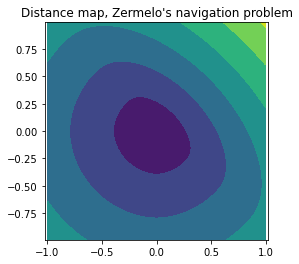

In [8]:
plt.figure(figsize=[4,4]); plt.title('Distance map, Zermelo\'s navigation problem'); plt.axis('equal'); 
plt.contourf(X,Y,hfmOut['values']);

Since the metric is constant, minimal geodesics are straight lines toward the origin.

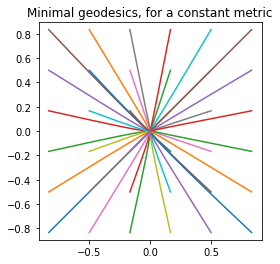

In [10]:
fig = plt.figure(figsize=[4,4]); plt.title('Minimal geodesics, for a constant metric'); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  plt.plot(*geo) 

## 2. Application to vessel segmentation

Non-symmetric metrics are well fit to extract structures possessing a preferred orientation. For instance, the contours of two dimensional objects are naturally oriented, by rotating the outward normal clockwise. See the notebook  [VI - Rander metrics](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/A6_Rander.ipynb)
 for a discussion on image sub-domain segmentation.

In the following experiment, we illustrate a different use of non-symmetric metrics, to avoid the shortcut's problem in tubular structure segmentation. A similar effect can be achieved with the use of non-holonomic metrics penalizing curvature, such as Euler-Mumford elasticae, see [IV - Curvature penalized planar paths](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/A4_Curvature.ipynb). 
Curvature penalization models can be simpler to use, but are much more computationally expensive.

### 2.1 Preparation of a synthetic example

In [11]:
def gamma(t):
    return ad.array((xp.cos(t),0.5*xp.sin(2*t)))
def gamma_tgt(t):
    tX,tY = -xp.sin(t),xp.cos(2*t)
    tN = xp.sqrt(tX**2+tY**2)
    return ad.array((tX/tN,tY/tN))    
def gamma_normal(t):
    tX,tY = gamma_tgt(t)
    return ad.array((tY,-tX))

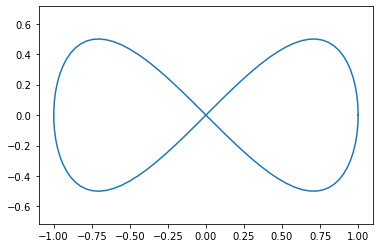

In [13]:
T=xp.linspace(0,2*np.pi,100)
plt.axis('equal')
plt.plot(*gamma(T));

The construction of our example involves running a first fast marching.

In [14]:
isoIn = Eikonal.dictIn({
    'model':'Isotropic2',
    'exportValues':1,
    'seeds':gamma(T).T, # Second T is transposition
    'speed':1,
    'seedValueVariation':gamma_tgt(T) # Interpolates data defined at the seeds
})

# Define the domain
n=201
isoIn.SetRect(sides=[[-1.1,1.1],[-0.6,0.6]],dimx=n)
X,Y = isoIn.Grid()

In [15]:
isoOut = isoIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.0034821033477783203 seconds, and 5 iterations.
Post-Processing


We computed the distance to the curve, and an extension of its tangents.

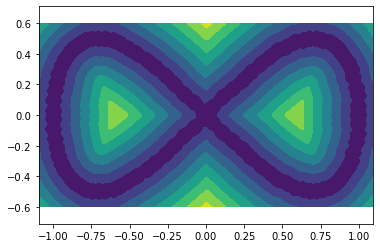

In [16]:
plt.contourf(X,Y,ad.remove_ad(isoOut['values'])); plt.axis('equal');

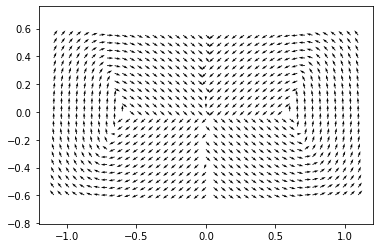

In [17]:
var = isoOut['values'].gradient()
plt.quiver(X[::5,::5],Y[::5,::5],var[0,::5,::5],var[1,::5,::5]); plt.axis('equal');

In [18]:
distGamma = ad.remove_ad(isoOut['values'])
baseSpeed = np.exp(-(distGamma/0.1)**2)+0.1
baseCost = 1/baseSpeed

tgtGammaX,tgtGammaY = var
tgtGammaN = np.sqrt(tgtGammaX**2+tgtGammaY**2)
tgtGammaX,tgtGammaY = tgtGammaX/tgtGammaN,tgtGammaY/tgtGammaN

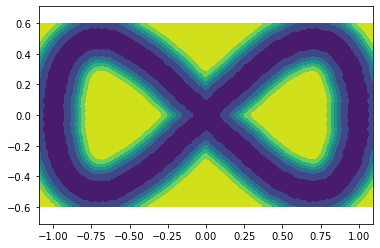

In [20]:
plt.contourf(X,Y,baseCost); plt.axis('equal');

### 2.2 Extraction of a tubular structure

In [21]:
hfmIn = Eikonal.dictIn({
    'model':'AsymmetricQuadratic2',
    'exportValues':1,
    'seed':[0.75,-0.5],
    'tip':[-0.75,-0.5]
})

# Define the domain
n=201
hfmIn.SetRect(sides=[[-1.1,1.1],[-0.6,0.6]],dimx=n)
X,Y = hfmIn.Grid()

In [22]:
hfmIn['metric']= AsymQuad(baseCost*fd.as_field(xp.eye(2),baseCost.shape), # D=baseCost*Id
                         [5*tgtGammaX,5*tgtGammaY]) # w

In [23]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.0574955940246582 seconds, and 96 iterations.
Post-Processing


The front propagates along the tubular structure. This propagation is asymmetric, since the direction proportional to the tangent is strongly penalized.

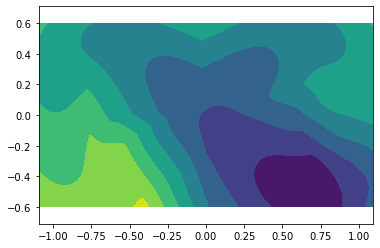

In [24]:
plt.contourf(X,Y,hfmOut['values']); plt.axis('equal');

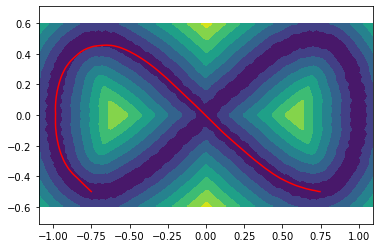

In [25]:
plt.contourf(X,Y,ad.remove_ad(isoOut['values'])); plt.axis('equal')
plt.plot(*hfmOut['geodesic'],color='red')

Exchanging the role of the seeds and tips yields the other half of the tubular structure, thanks to the metric asymmetry.

In [26]:
hfmIn['seed'],hfmIn['tip'] = hfmIn['tip'],hfmIn['seed'] 

In [27]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.05749678611755371 seconds, and 97 iterations.
Post-Processing


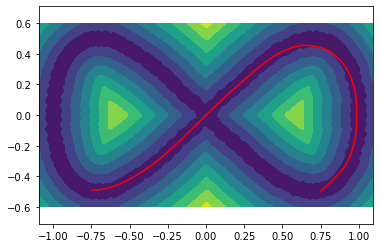

In [28]:
plt.contourf(X,Y,ad.remove_ad(isoOut['values'])); plt.axis('equal')
plt.plot(*hfmOut['geodesic'],color='red');

In contrast, a symmetric metric cannot recover such a structure, due to the shortcuts problem.

In [29]:
hfmIn['metric'] = AsymQuad(hfmIn['metric'].m,[0,0])

In [30]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.0204770565032959 seconds, and 40 iterations.
Post-Processing


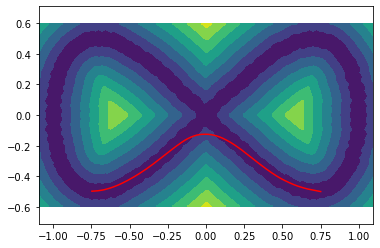

In [31]:
plt.contourf(X,Y,ad.remove_ad(isoOut['values'])); plt.axis('equal')
plt.plot(*hfmOut['geodesic'],color='red');